因子1 Alpha191 alpha24

3.7230749130249023
Initialize dataview success.


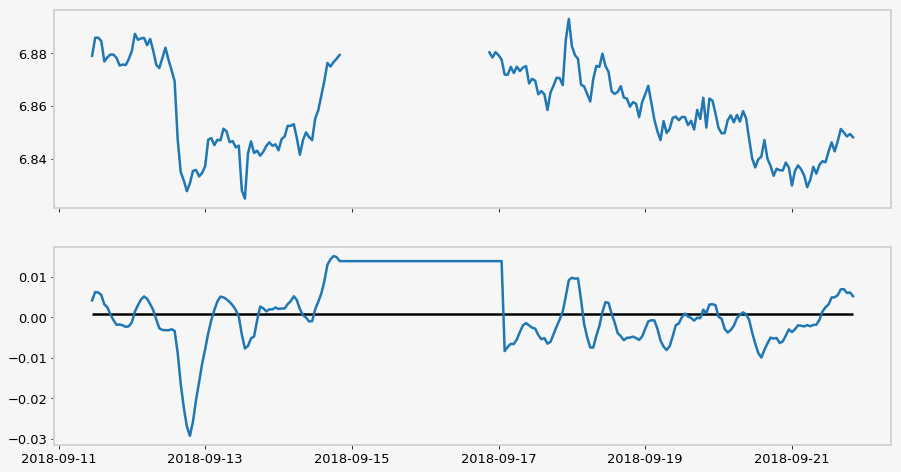

In [189]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/OANDA_M1'
props = {'fields': 'open,high,low,close,volume','symbol': 'USD_CNH:oanda', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
import matplotlib.pyplot as plt

def plot_chart(close,alpha,alpha_mean=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    ax1.hlines(alpha_mean, alpha.index[-250], alpha.index[-1])
    # plt.savefig('good')
    plt.show()
def RankPct(df):
    return df.rank(axis=1, pct=True)
alpha24 = dv.add_formula('alpha24','Sma(close-Delay(close,5),5,1)',add_data=True, register_funcs={'RankPct':RankPct})
import numpy as np
a=np.nan_to_num(alpha24.values)
alpha24_mean=np.mean(a)
alpha24_plot = dv.get_ts('alpha24', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha24_plot,alpha24_mean)

In [190]:
np.mean(a)

0.00082097971660189967

In [191]:

# 进场信号
long = dv.add_formula('longAlpha24','If(Sma(close-Delay(close,5),5,1)>0.00082097971660189967 ,2,0)', add_data=True)
short = dv.add_formula("shortAlpha24","If(Sma(close-Delay(close,5),5,1)<=0.00082097971660189967 ,-2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongAlpha24","If(shortAlpha24==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha24","If(longAlpha24==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha024')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha1, dv,'longAlpha24','shortAlpha24','closeLongAlpha24','closeShortAlpha24', 100, 0.05, 0.3)
tdAlpha1.create_event_report(sig_type="long_short")


Nan Data Count (should be zero) : 0;  Percentage of effective data: 36%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 34%
*****-Summary-*****
Event Analysis
                        win      loss       all
t-stat               19.799   -53.823   -21.077
p-value               0.000     0.000     0.000
mean                  0.002    -0.002    -0.001
std                   0.002     0.001     0.002
info_ratio            1.003    -1.379    -0.482
skewness              1.493    -1.615     0.945
kurtosis              2.191     4.254     3.800
pct5                  0.000    -0.005    -0.004
pct25                 0.000    -0.003    -0.002
pct50                 0.002    -0.002    -0.001
pct75                 0.003    -0.001    -0.000
pct95                 0.007    -0.000     0.003
occurance           391.000  1524.000  1915.000
win_ratio               NaN       NaN     0.204
win_mean/loss_mean      NaN       NaN     1.112


In [192]:
tdAlpha1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               17.861  -34.314  -11.427
p-value               0.000    0.000    0.000
mean                  0.002   -0.002   -0.001
std                   0.002    0.002    0.003
info_ratio            1.134   -1.267   -0.365
skewness              1.042   -1.769    0.497
kurtosis              0.399    4.586    2.018
pct5                  0.000   -0.005   -0.005
pct25                 0.001   -0.003   -0.002
pct50                 0.002   -0.002   -0.001
pct75                 0.003   -0.001    0.000
pct95                 0.007   -0.000    0.004
occurance           249.000  734.000  983.000
win_ratio               NaN      NaN    0.253
win_mean/loss_mean      NaN      NaN    1.137


In [193]:
tdAlpha1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                9.767  -43.269  -19.765
p-value               0.000    0.000    0.000
mean                  0.002   -0.002   -0.001
std                   0.002    0.001    0.002
info_ratio            0.823   -1.540   -0.648
skewness              2.038   -1.115    1.687
kurtosis              4.052    1.399    7.767
pct5                  0.000   -0.004   -0.004
pct25                 0.000   -0.003   -0.002
pct50                 0.001   -0.002   -0.001
pct75                 0.003   -0.001   -0.001
pct95                 0.007   -0.000    0.002
occurance           142.000  790.000  932.000
win_ratio               NaN      NaN    0.152
win_mean/loss_mean      NaN      NaN    1.036


前面所写的程序使用alpha191的第24个因子（公式为Sma(close-Delay(close,5),5,1)），从前面的图中我们可以看出，输出的alpha因子将价格变化变得更加平滑，同时没有像其他的均线一样出现延后的情况，当alpha24因子一旦越过平均线0.00082097971660189967，价格图表也将出现明显的下跌或者上升，此因子有一定的预测作用。

因此，我假设当alpha24因子跌破其均线时，就做空美元，当alpha24因子涨过其均线时，就做多美元。

对因子进行绩效分析之后发现，该因子的盈亏比超过1，但win_ratio较低。

增加EOS对alpha24因子的绩效表：

Initialize dataview success.


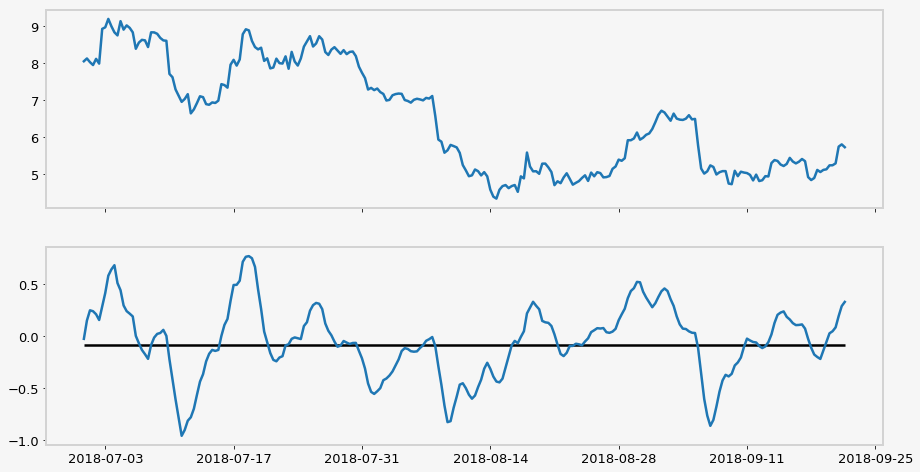

In [194]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '8H',
         'start_date':20180401000000}

Time_dict = ds.bar_reader(path,props)
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()
dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
import matplotlib.pyplot as plt

def plot_chart(close,alpha,alpha_mean=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    ax1.hlines(alpha_mean, alpha.index[-250], alpha.index[-1])
    # plt.savefig('good')
    plt.show()
def RankPct(df):
    return df.rank(axis=1, pct=True)
alpha24 = dv.add_formula('alpha24','Sma(close-Delay(close,5),5,1)',add_data=True, register_funcs={'RankPct':RankPct})
import numpy as np
a=np.nan_to_num(alpha24.values)
alpha24_mean=np.mean(a)
alpha24_plot = dv.get_ts('alpha24', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')
plot_chart(close, alpha24_plot,alpha24_mean)

In [195]:
alpha24_mean

-0.087402411941079255

In [196]:

# 进场信号
short = dv.add_formula('shortAlpha24','If(Sma(close-Delay(close,5),5,1)>-0.087402411941079255 ,-2,0)', add_data=True)
long = dv.add_formula("longAlpha24","If(Sma(close-Delay(close,5),5,1)<=-0.087402411941079255 ,2,0)", add_data=True)

# 出场信号
close_long = dv.add_formula("closeLongAlpha24","If(shortAlpha24==-2,1,0)", add_data=True)
close_short = dv.add_formula("closeShortAlpha24","If(longAlpha24==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha024')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdAlpha1, dv,'longAlpha24','shortAlpha24','closeLongAlpha24','closeShortAlpha24', 100, 0.05, 0.3)
tdAlpha1.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 45%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 53%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               15.787  -19.828    0.610
p-value               0.000    0.000    0.542
mean                  0.071   -0.066    0.003
std                   0.059    0.043    0.086
info_ratio            1.211   -1.525    0.033
skewness              1.112   -0.895    0.378
kurtosis              0.463    0.864    0.051
pct5                  0.005   -0.152   -0.118
pct25                 0.028   -0.086   -0.061
pct50                 0.059   -0.061    0.000
pct75                 0.096   -0.034    0.059
pct95                 0.205   -0.005    0.166
occurance           171.000  170.000  341.000
win_ratio               NaN      NaN    0.501
win_mean/loss_mean      NaN      NaN    1.080


In [197]:
tdAlpha1.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              10.483 -14.914   -3.039
p-value              0.000   0.000    0.003
mean                 0.045  -0.057   -0.015
std                  0.034   0.036    0.061
info_ratio           1.310  -1.563   -0.243
skewness             0.541  -0.671    0.091
kurtosis            -0.689   0.490   -0.477
pct5                 0.003  -0.122   -0.104
pct25                0.014  -0.077   -0.061
pct50                0.041  -0.058   -0.014
pct75                0.069  -0.024    0.025
pct95                0.110  -0.004    0.095
occurance           65.000  92.000  157.000
win_ratio              NaN     NaN    0.414
win_mean/loss_mean     NaN     NaN    0.783


In [198]:
tdAlpha1.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win    loss      all
t-stat               13.884 -13.985    2.444
p-value               0.000   0.000    0.015
mean                  0.087  -0.076    0.018
std                   0.065   0.048    0.100
info_ratio            1.355  -1.594    0.181
skewness              0.787  -0.801    0.147
kurtosis             -0.556   0.308   -0.481
pct5                  0.011  -0.185   -0.136
pct25                 0.035  -0.098   -0.059
pct50                 0.068  -0.069    0.023
pct75                 0.119  -0.052    0.076
pct95                 0.212  -0.008    0.204
occurance           106.000  78.000  184.000
win_ratio               NaN     NaN    0.576
win_mean/loss_mean      NaN     NaN    1.145


因子2 蜡烛图形态Hammer和Hikkake

Initialize dataview success.
symbol               BTCUSDT:binance
trade_date                          
2018-09-03 09:00:00            100.0
2018-09-05 11:00:00            100.0
2018-09-05 23:00:00            100.0
2018-09-06 11:00:00            100.0
2018-09-07 12:00:00            100.0
2018-09-09 08:00:00            100.0
2018-09-10 11:00:00            100.0
2018-09-11 06:00:00            100.0
2018-09-12 01:00:00            100.0
2018-09-15 14:00:00            100.0
2018-09-16 22:00:00            100.0
2018-09-18 10:00:00            100.0
2018-09-19 08:00:00            100.0
2018-09-20 07:00:00            100.0
2018-09-20 13:00:00            100.0
2018-09-21 13:00:00            100.0


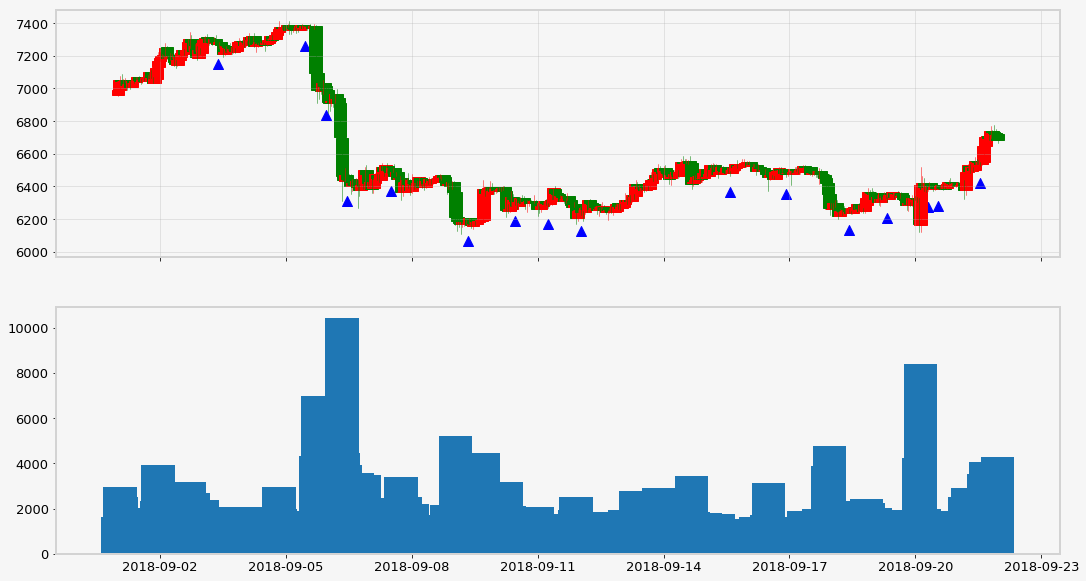

In [199]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '1H',
         'start_date':20180901000000}

Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
HAMMER = dv1H.add_formula('HAMMER', "If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HAMMERVolume = dv1H.get_ts('HAMMER', date_type='datetime')
print(HAMMERVolume[HAMMERVolume['BTCUSDT:binance']==100])

from matplotlib.pylab import date2num
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
HAMMERVolumeX = HAMMERVolume[HAMMERVolume['BTCUSDT:binance']==100].index
HAMMERVolumeY = data1H.loc[HAMMERVolumeX].low-100
draw_candle(candle, HAMMERVolumeX, HAMMERVolumeY)

symbol               BTCUSDT:binance
trade_date                          
2018-09-02 08:00:00            100.0
2018-09-02 19:00:00            100.0
2018-09-02 21:00:00            100.0
2018-09-03 06:00:00            100.0
2018-09-05 11:00:00            100.0
2018-09-05 23:00:00            100.0
2018-09-07 12:00:00            100.0
2018-09-07 16:00:00            100.0
2018-09-07 18:00:00            100.0
2018-09-08 03:00:00            100.0
2018-09-08 22:00:00            100.0
2018-09-09 04:00:00            100.0
2018-09-09 08:00:00            100.0
2018-09-10 11:00:00            100.0
2018-09-10 21:00:00            100.0
2018-09-11 12:00:00            100.0
2018-09-13 10:00:00            100.0
2018-09-13 19:00:00            100.0
2018-09-13 23:00:00            100.0
2018-09-14 21:00:00            100.0
2018-09-15 11:00:00            100.0
2018-09-16 05:00:00            100.0
2018-09-16 08:00:00            100.0
2018-09-16 15:00:00            100.0
2018-09-16 20:00:00            100.0
2

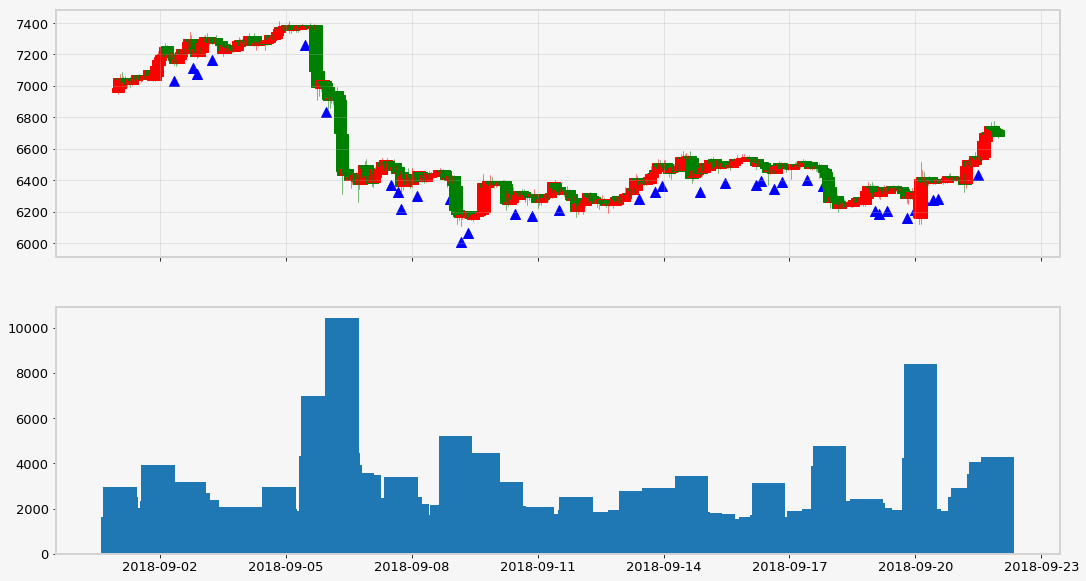

In [200]:
HIKKAKE = dv1H.add_formula('HIKKAKE', "If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HIKKAKEVolume = dv1H.get_ts('HIKKAKE', date_type='datetime')
print(HIKKAKEVolume[HIKKAKEVolume['BTCUSDT:binance']==100])
HIKKAKEVolumeX = HIKKAKEVolume[HIKKAKEVolume['BTCUSDT:binance']==100].index
HIKKAKEVolumeY = data1H.loc[HIKKAKEVolumeX].low-100
draw_candle(candle, HIKKAKEVolumeX,HIKKAKEVolumeY)

In [201]:
long = dv1H.add_formula('longCandle',"If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100) ,2,0)", add_data=True)
short = dv1H.add_formula("shortCandle","If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongCandle","If(shortCandle==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortCandle","If(longCandle==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdCandle= TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdCandle, dv1H,'longCandle','shortCandle','closeLongCandle','closeShortCandle', 100, 0.05, 0.3)
tdCandle.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.737  -4.594   1.761
p-value              0.000   0.000   0.087
mean                 0.016  -0.007   0.005
std                  0.014   0.006   0.016
info_ratio           1.116  -1.114   0.294
skewness             0.560  -0.994   0.832
kurtosis            -1.226  -0.443  -0.029
pct5                 0.001  -0.020  -0.018
pct25                0.003  -0.008  -0.005
pct50                0.011  -0.005   0.001
pct75                0.028  -0.003   0.011
pct95                0.038  -0.001   0.038
occurance           19.000  18.000  37.000
win_ratio              NaN     NaN   0.514
win_mean/loss_mean     NaN     NaN   2.233


In [202]:
tdCandle.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win      loss    all
t-stat              3.621       NaN  2.734
p-value             0.011       NaN  0.029
mean                0.010 -0.004000  0.008
std                 0.007  0.000000  0.008
info_ratio          1.478      -inf  1.033
skewness            0.652  0.000000  0.293
kurtosis           -0.664 -3.000000 -0.586
pct5                0.003 -0.004000 -0.002
pct25               0.004 -0.004000  0.003
pct50               0.010 -0.004000  0.007
pct75               0.013 -0.004000  0.012
pct95               0.020 -0.004000  0.020
occurance           7.000  1.000000  8.000
win_ratio             NaN       NaN  0.875
win_mean/loss_mean    NaN       NaN  2.248


In [203]:
tdCandle.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               3.997  -4.455   1.144
p-value              0.002   0.000   0.262
mean                 0.019  -0.007   0.004
std                  0.016   0.007   0.017
info_ratio           1.205  -1.114   0.216
skewness             0.051  -0.912   0.929
kurtosis            -1.739  -0.627  -0.215
pct5                 0.001  -0.020  -0.019
pct25                0.002  -0.008  -0.006
pct50                0.019  -0.005  -0.001
pct75                0.035  -0.003   0.005
pct95                0.040  -0.001   0.038
occurance           12.000  17.000  29.000
win_ratio              NaN     NaN   0.414
win_mean/loss_mean     NaN     NaN   2.673


第二部分使用了蜡烛图的两个形态同时作为对比特币投资的决策因子。首先画的图是形态Hammer出现时间与价格的走势图，从图中可以看出，大部分时间该形态都出现在一波涨势之前，但未观察到其于交易量的关系。第二个画的图为形态Hikkake出现时间与价格的走势图，从图中可以看出，当大市暴跌时，该形态都做出了预测，同时在大部分时间，市场都会在该指标出现之后有少许下跌，同时可以观察到，该指标会让比特币交易量有所提升。

因此，我们做出假设，当出现Hammer形态时我们可以做多；在出现Hikkake形态时，我们可以做空。

对因子进行绩效分析之后发现，该因子无论是盈亏比还是win_ratio都不太理想，但是单边做多的策略是三者中表现最好的一个，可以猜测Hammer形态对预测涨势有较好效果。

Initialize dataview success.
symbol               EOSUSDT:binance
trade_date                          
2018-06-04 06:00:00            100.0
2018-06-05 19:00:00            100.0
2018-06-08 12:00:00            100.0
2018-06-08 16:00:00            100.0
2018-06-10 10:00:00            100.0
2018-06-12 04:00:00            100.0
2018-06-13 14:00:00            100.0
2018-06-14 18:00:00            100.0
2018-06-17 03:00:00            100.0
2018-06-18 21:00:00            100.0
2018-06-19 07:00:00            100.0
2018-06-20 02:00:00            100.0
2018-06-23 20:00:00            100.0
2018-06-24 14:00:00            100.0
2018-06-24 20:00:00            100.0
2018-06-25 15:00:00            100.0
2018-06-27 10:00:00            100.0
2018-06-29 01:00:00            100.0
2018-06-29 19:00:00            100.0
2018-06-30 03:00:00            100.0
2018-07-02 03:00:00            100.0
2018-07-03 06:00:00            100.0
2018-07-03 07:00:00            100.0
2018-07-03 14:00:00            100.0
2018-07-0

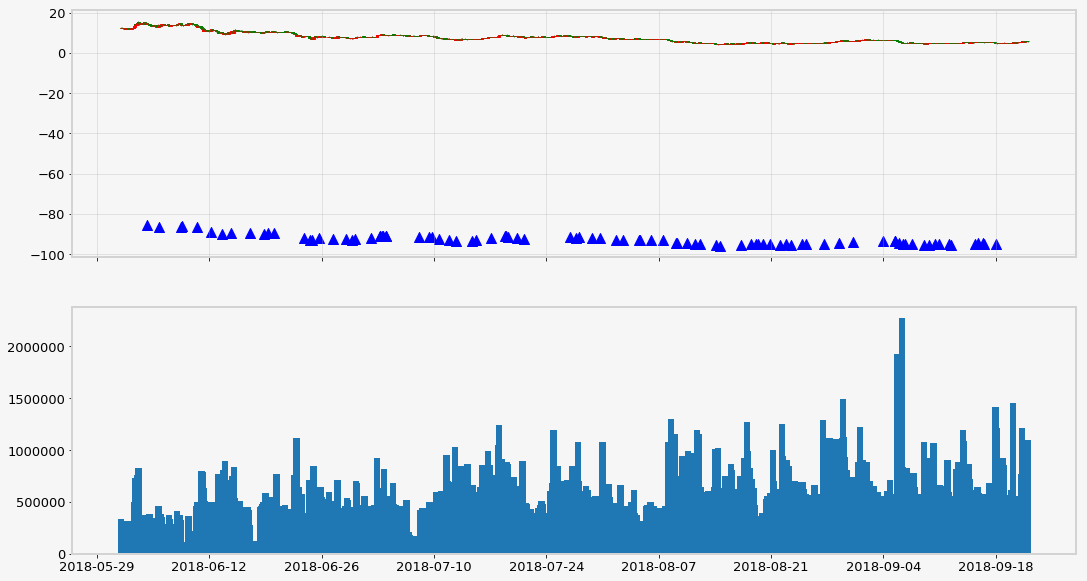

In [204]:
import warnings

warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'./min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'EOSUSDT:binance', 'freq': '1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props)
data2H = Time_dict.set_index('datetime')
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv2H = HFDataView()
dv2H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
HAMMER = dv2H.add_formula('HAMMER', "If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HAMMERVolume = dv2H.get_ts('HAMMER', date_type='datetime')
print(HAMMERVolume[HAMMERVolume['EOSUSDT:binance']==100])

from matplotlib.pylab import date2num
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data2H.index, data2H.volume)
    plt.show()
data2H['candleTime'] = list(map(date2num, data2H.index))
candle = data2H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values
HAMMERVolumeX = HAMMERVolume[HAMMERVolume['EOSUSDT:binance']==100].index
HAMMERVolumeY = data2H.loc[HAMMERVolumeX].low-100
draw_candle(candle, HAMMERVolumeX, HAMMERVolumeY)

symbol               EOSUSDT:binance
trade_date                          
2018-06-01 09:00:00            100.0
2018-06-02 20:00:00            100.0
2018-06-03 11:00:00            100.0
2018-06-04 00:00:00            100.0
2018-06-04 13:00:00            100.0
2018-06-04 19:00:00            100.0
2018-06-05 10:00:00            100.0
2018-06-05 18:00:00            100.0
2018-06-07 02:00:00            100.0
2018-06-07 14:00:00            100.0
2018-06-08 18:00:00            100.0
2018-06-09 13:00:00            100.0
2018-06-09 16:00:00            100.0
2018-06-10 10:00:00            100.0
2018-06-10 23:00:00            100.0
2018-06-11 04:00:00            100.0
2018-06-11 09:00:00            100.0
2018-06-13 02:00:00            100.0
2018-06-13 07:00:00            100.0
2018-06-14 23:00:00            100.0
2018-06-15 06:00:00            100.0
2018-06-15 09:00:00            100.0
2018-06-15 16:00:00            100.0
2018-06-16 03:00:00            100.0
2018-06-16 16:00:00            100.0
2

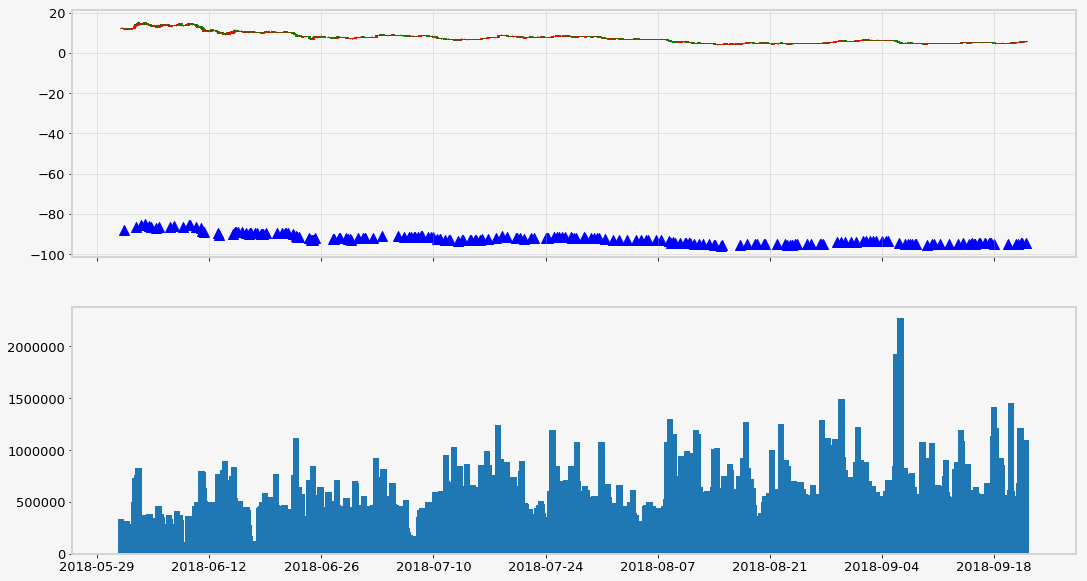

In [205]:
HIKKAKE = dv2H.add_formula('HIKKAKE', "If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
HIKKAKEVolume = dv2H.get_ts('HIKKAKE', date_type='datetime')
print(HIKKAKEVolume[HIKKAKEVolume['EOSUSDT:binance']==100])
HIKKAKEVolumeX = HIKKAKEVolume[HIKKAKEVolume['EOSUSDT:binance']==100].index
HIKKAKEVolumeY = data2H.loc[HIKKAKEVolumeX].low-100
draw_candle(candle, HIKKAKEVolumeX,HIKKAKEVolumeY)

In [206]:
long = dv2H.add_formula('longCandle',"If((Ta('CDLHAMMER', 0, open, high, low, close, volume)==100) ,2,0)", add_data=True)
short = dv2H.add_formula("shortCandle","If((Ta('CDLHIKKAKE', 0, open, high, low, close, volume)==100),-2,0)", add_data=True)

# 出场信号
close_long = dv2H.add_formula("closeLongCandle","If(shortCandle==-2,1,0)", add_data=True)
close_short = dv2H.add_formula("closeShortCandle","If(longCandle==2,-1,0)", add_data=True)
from jaqs_fxdayu.research import TimingDigger

tdCandle= TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')
def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdCandle, dv2H,'longCandle','shortCandle','closeLongCandle','closeShortCandle', 100, 0.05, 0.3)
tdCandle.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 3%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 7%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               10.232  -13.766    1.256
p-value               0.000    0.000    0.210
mean                  0.039   -0.033    0.004
std                   0.043    0.026    0.051
info_ratio            0.904   -1.246    0.079
skewness              2.064   -0.557    1.079
kurtosis              4.363   -0.831    2.668
pct5                  0.001   -0.083   -0.066
pct25                 0.011   -0.056   -0.023
pct50                 0.025   -0.026    0.000
pct75                 0.051   -0.010    0.026
pct95                 0.122   -0.002    0.091
occurance           129.000  123.000  252.000
win_ratio               NaN      NaN    0.512
win_mean/loss_mean      NaN      NaN    1.194


In [207]:
tdCandle.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.708  -8.531  -1.785
p-value              0.000   0.000   0.079
mean                 0.022  -0.030  -0.008
std                  0.025   0.021   0.034
info_ratio           0.890  -1.384  -0.218
skewness             2.181  -0.488   0.565
kurtosis             4.635  -1.113   1.345
pct5                 0.001  -0.063  -0.059
pct25                0.007  -0.050  -0.030
pct50                0.015  -0.023  -0.008
pct75                0.030  -0.011   0.012
pct95                0.074  -0.006   0.040
occurance           29.000  39.000  68.000
win_ratio              NaN     NaN   0.426
win_mean/loss_mean     NaN     NaN   0.750


In [208]:
tdCandle.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win    loss      all
t-stat                9.505 -11.086    2.032
p-value               0.000   0.000    0.044
mean                  0.044  -0.034    0.008
std                   0.046   0.028    0.055
info_ratio            0.955  -1.217    0.150
skewness              1.885  -0.495    0.970
kurtosis              3.365  -0.981    2.045
pct5                  0.002  -0.086   -0.068
pct25                 0.014  -0.057   -0.021
pct50                 0.028  -0.027    0.004
pct75                 0.059  -0.009    0.029
pct95                 0.166  -0.001    0.099
occurance           100.000  84.000  184.000
win_ratio               NaN     NaN    0.543
win_mean/loss_mean      NaN     NaN    1.284
